# Analisi sulle formazioni iniziali ed il turn-over nelle prime giornate di Serie A 2022-23
## [dati Wyscout]

In [1]:
# Initial environment setup
import requests
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib import rcParams

from PIL import Image
import urllib
import matplotlib.font_manager as fm
from highlight_text import fig_text

import os

username = 'qjpuw3t-yf3bvhgms-8d0gift-bm2fprvs4z'
token =  '7*.w$Ivko$FpRsbumn0gF(0Kc5yMAI'

base_url = 'https://apirest.wyscout.com/v3{}'


In [2]:
# font setup
font_path = "../Fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f'{font_path}/{x}'):
        if y.split('.')[-1] == 'ttf':
            fm.fontManager.addfont(f'{font_path}/{x}/{y}')
            try:
                fm.FontProperties(weight=y.split('-')[-1].split('.')[0].lower(), fname=y)
            except Exception as e:
                print(f'Font {y} could not be added.')
                continue

rcParams['font.family'] = 'DMSans'

Font DMSans-BoldItalic.ttf could not be added.
Font DMSans-Italic.ttf could not be added.
Font DMSans-MediumItalic.ttf could not be added.
Font Karla-BoldItalic.ttf could not be added.
Font Karla-Italic.ttf could not be added.


Players, Teams Data Download from WyScout API

In [3]:
SerieA = 524

A_Season_21_22 = 187528
A_Season_20_21 = 186353
A_Season_19_20 = 186353
A_Season_22_23 = 188160

FiorentinaId = 3176
SpeziaId = 3205
available_seasons = [(SerieA,A_Season_22_23)]

players,teams = [],[]
players_season = {}

for season in available_seasons:
    api_url = base_url.format(f'/seasons/{season[1]}/teams')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team = response.json()['teams']
        teams+=team


team_name = {}
for team in teams:
  team_name[team['wyId']] = team['name']

match details V3 - 2022/23

In [4]:
matches = []

for season in available_seasons:
    
  api_url = base_url.format(f'/competitions/{SerieA}/matches')
  response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
  if response.ok:
    season_matches = response.json()['matches']
  else:
    print("errore")
    break
  last_season_matches = []
  for match in season_matches:
    if match['seasonId'] == season[1]:
      last_season_matches.append(match)
  for m in tqdm(last_season_matches):
        
    api_url = base_url.format('/matches/%s'%(m['matchId']))
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      matches.append(response.json())

  for team in team_name.keys():
    api_url = base_url.format(f'/teams/{team}/squad?seasonId={season[1]}')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      player = response.json()['squad']
      players+=player
    for p in player:
      players_season[p['wyId']] = season
    
        
player_name = {}
for p in players:
  player_name[p['wyId']] = [p['shortName'], p['role']['code3']]

team_name = {}
for t in teams:
  team_name[t['wyId']] = t['name']

match_name = {}
for m in matches:
  match_name[m['wyId']] = m['label']

100%|██████████| 60/60 [00:24<00:00,  2.47it/s]


In [5]:
team_lineups = {}

for team in tqdm(team_name.keys()):
    api_url = base_url.format(f'/teams/{team}/matches?seasonId={A_Season_22_23}')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team_matches = response.json()['matches']
    lineup_matches_list = []
    for match in team_matches:
        api_url = base_url.format(f'/matches/{match["matchId"]}')
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            lineup_list = response.json()['teamsData'][str(team)]['formation']['lineup']
        lineup = []
        for lin in lineup_list:
            lineup.append(lin['playerId'])
        lineup_matches_list.append(lineup)
    team_lineups[team] = lineup_matches_list



100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


### Advanced Stats

In [6]:
players,teams = [],[]
players_season = {}
available_seasons = [(SerieA,A_Season_22_23)]


for season in available_seasons:
    api_url = base_url.format(f'/seasons/{season[1]}/teams')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team = response.json()['teams']
        teams+=team

team_name = {}
for team in teams:
  team_name[team['wyId']] = team['name']

for season in available_seasons:
    for team in team_name.keys():
        api_url = base_url.format(f'/teams/{team}/squad?seasonId={season[1]}')
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            player = response.json()['squad']
            players+=player

advanced_stats = []

players_df = pd.json_normalize(players)
players_df.drop_duplicates(inplace=True, ignore_index=True)

api_url = base_url.format(f'/seasons/{A_Season_22_23}/teams')
response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
if response.ok:
  teams = response.json()['teams']
teams_df = pd.DataFrame(teams)


for i, player in tqdm(players_df.iterrows()):
  api_url = base_url.format(f'/players/{player["wyId"]}/advancedstats?compId=524&seasonId={A_Season_22_23}')
  response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
  if response.ok:
    player_as = response.json()
    advanced_stats.append(player_as)

advanced_stats_df = pd.DataFrame(advanced_stats)
advanced_stats_total_df = pd.json_normalize(advanced_stats_df['total'])

advanced_stats_complete = pd.concat([advanced_stats_df, advanced_stats_total_df], axis=1)
advanced_stats_complete.rename(columns={'playerId':'wyId'}, inplace=True)

577it [07:25,  1.29it/s]


In [7]:
cols = [
    'wyId',
    'shortName',
    'currentTeamId'
]

players_df_short = players_df[cols]

In [8]:
cols1 = [
    'wyId',
    'matches',
    'matchesInStart',
    'minutesOnField'
]

In [9]:
advanced_stats_short = advanced_stats_complete[cols1]

In [10]:
dataset = advanced_stats_short.merge(players_df_short, on = 'wyId', how='left').reset_index(drop=True)
dataset_clean = dataset.dropna(axis=0)
dataset_clean['currentTeamId'] = dataset_clean['currentTeamId'].astype(int)

C:\Users\fgron\AppData\Local\Temp\ipykernel_11308\1368401146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['currentTeamId'] = dataset_clean['currentTeamId'].astype(int)


In [32]:
# preprocessing
team_name_tmp = pd.Series(team_name, name='shortName')
team_name_df = team_name_tmp.to_frame()
team_name_df.reset_index(inplace=True)
team_name_df.rename(columns={'index':'currentTeamId'},inplace=True)
player_presence_df = pd.merge(dataset_clean, team_name_df, how='left')

In [33]:
player_on_field_df = player_presence_df.groupby(['currentTeamId','wyId','shortName']).sum()
player_on_field_df = player_on_field_df[player_on_field_df.minutesOnField != 0]
player_on_field_df.reset_index(inplace=True)

different_player_per_team = player_on_field_df.groupby('currentTeamId').count()['wyId']
different_player_per_team = different_player_per_team.reset_index()
different_player_per_team.rename(columns={'wyId':'PlayersOnField', 'currentTeamId':'teamId'}, inplace=True)
different_player_per_team.sort_values(by='PlayersOnField', inplace=True, ascending=False)
different_player_per_team.reset_index(inplace=True, drop=True)

different_player_per_team_ok = different_player_per_team[(different_player_per_team.teamId != 3715) & (different_player_per_team.teamId != 3171) & (different_player_per_team.teamId != 3179)]

team_name_tmp = pd.Series(team_name, name='team')
team_name_df = team_name_tmp.to_frame()
team_name_df.reset_index(inplace=True)
team_name_df.rename(columns={'index':'teamId'},inplace=True)

different_player_per_team_df = pd.merge(different_player_per_team_ok, team_name_df, how='left')

In [34]:
teams = ['Fiorentina',
         'Milan',
         'Atalanta',
         'Bologna',
         'Cremonese',
         'Empoli',
         'Hellas Verona',
         'Internazionale',
         'Juventus',
         'Lazio',
         'Lecce',
         'Monza',
         'Roma',
         'Napoli',
         'Salernitana',
         'Sampdoria',
         'Sassuolo',
         'Spezia',
         'Torino',
         'Udinese',
         'Genoa',
         'Cagliari',
         'Venezia',
         'Benevento',
         'Crotone',
         'Parma',
         'Brescia',
         'Spal']

footId = [8535,
          8564,
          8524,
          9857,
          7801,
          8534,
          9876,
          8636,
          9885,
          8543,
          9888,
          6504,
          8686,
          9875,
          6480,
          9882,
          7943,
          9881,
          9804,
          8600,
          10233,
          8529,
          7881,
          6266,
          9884,
          10167,
          9858,
          8547]

footTeams = pd.DataFrame({'team': teams,
                   'footId': footId})

In [35]:
different_player_per_team_b = pd.merge(different_player_per_team_df, footTeams, how = "left")

different_player_per_team_b.replace({
    "team":{
         'Fiorentina' : 'FIO',
         'Milan':'MIL',
         'Atalanta':'ATA',
         'Bologna':'BOL',
         'Cremonese':'CRE',
         'Empoli':'EMP',
         'Hellas Verona':'VER',
         'Internazionale':'INT',
         'Juventus':'JUV',
         'Lazio':'LAZ',
         'Lecce':'LEC',
         'Monza':'MON',
         'Roma':'ROM',
         'Napoli':'NAP',
         'Salernitana':'SAL',
         'Sampdoria':'SAM',
         'Sassuolo':'SAS',
         'Spezia':'SPE',
         'Torino':'TOR',
         'Udinese':'UDI',
         'Genoa':'GEN',
         'Cagliari':'CAG',
         'Venezia':'VEN',
         'Benevento':'BEN',
         'Crotone':'CRO',
         'Parma':'PAR',
         'Brescia':'BRE',
         'Spal':'SPA'
    }
}, inplace = True)

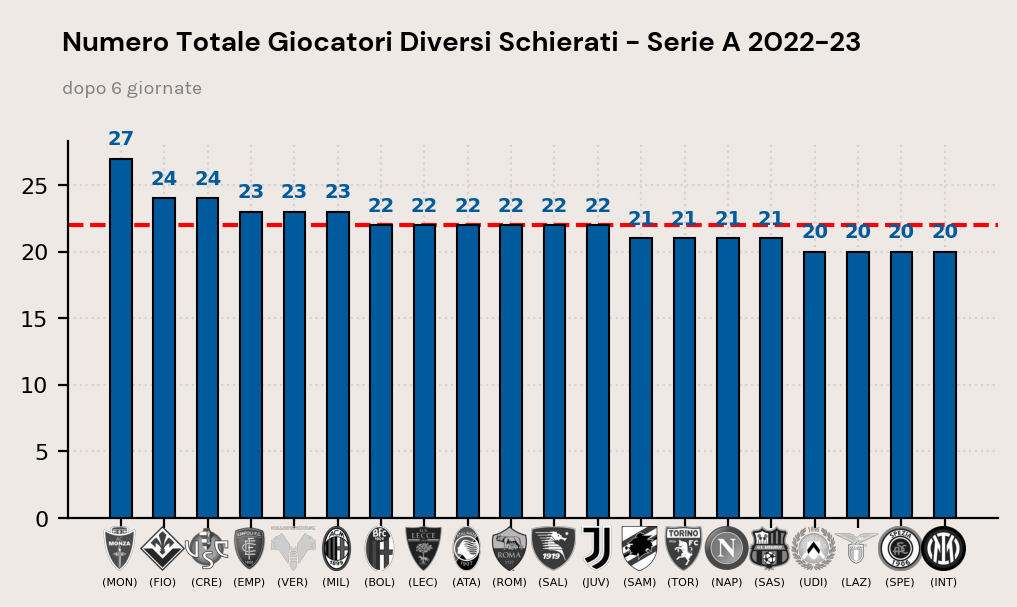

In [36]:
X_2223=different_player_per_team_b.index
height_2223 = different_player_per_team_b.PlayersOnField

sb_2223_avg = different_player_per_team_b['PlayersOnField'].mean()
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")

# We specify the width of the bar
width = 0.5

# Second balls
ax.bar(
    X_2223, 
    height_2223,
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = width,
    label = "Second ball"
)

ax.axhline(y=sb_2223_avg, color='red', linestyle='--', label='average')

for index, y in enumerate(height_2223):
    ax.annotate(
        xy = (index, y),
        text = f"{y:.0f}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 7,
        color = "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

xticks_ = ax.xaxis.set_ticks(
    ticks = X_2223,
    labels = []
    )

ax.tick_params(labelsize = 8)


# --- Axes transformations

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform

# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, team_id in enumerate(different_player_per_team_b["footId"]):
    ax_coords = DC_to_NFC([index - 1.1*width, -4])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.09, 0.09], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")

    logo_ax.annotate(
        xy =(0, 0),
        text = f"({different_player_per_team_b['team'].iloc[index]})",
        xytext = (8, -20),
        textcoords = "offset points",
        size = 4,
        ha = "center",
        va = "center"
    )

fig_text(
    x = 0.12, y = 1.1,
    s = "Numero Totale Giocatori Diversi Schierati - Serie A 2022-23",
    family = "DM Sans",
    weight = "bold",
    size = 10
)
fig_text(
    x = 0.12, y = 1,
    s = "dopo 6 giornate",
    family = "Karla",
    color = "grey",
    size = 7
)

plt.show()

In [37]:
player_on_field_df = player_presence_df.groupby(['currentTeamId','wyId','shortName']).sum()
player_on_field_df = player_on_field_df[player_on_field_df.minutesOnField >= 90]
player_on_field_df.reset_index(inplace=True)

different_player_per_team = player_on_field_df.groupby('currentTeamId').count()['wyId']
different_player_per_team = different_player_per_team.reset_index()
different_player_per_team.rename(columns={'wyId':'PlayersOnField', 'currentTeamId':'teamId'}, inplace=True)
different_player_per_team.sort_values(by='PlayersOnField', inplace=True, ascending=False)
different_player_per_team.reset_index(inplace=True, drop=True)

different_player_per_team_ok = different_player_per_team[(different_player_per_team.teamId != 3715) & (different_player_per_team.teamId != 3171)]

team_name_tmp = pd.Series(team_name, name='team')
team_name_df = team_name_tmp.to_frame()
team_name_df.reset_index(inplace=True)
team_name_df.rename(columns={'index':'teamId'},inplace=True)

different_player_per_team_df = pd.merge(different_player_per_team_ok, team_name_df, how='left')


In [38]:
different_player_per_team_b = pd.merge(different_player_per_team_df, footTeams, how = "left")

different_player_per_team_b.replace({
    "team":{
         'Fiorentina' : 'FIO',
         'Milan':'MIL',
         'Atalanta':'ATA',
         'Bologna':'BOL',
         'Cremonese':'CRE',
         'Empoli':'EMP',
         'Hellas Verona':'VER',
         'Internazionale':'INT',
         'Juventus':'JUV',
         'Lazio':'LAZ',
         'Lecce':'LEC',
         'Monza':'MON',
         'Roma':'ROM',
         'Napoli':'NAP',
         'Salernitana':'SAL',
         'Sampdoria':'SAM',
         'Sassuolo':'SAS',
         'Spezia':'SPE',
         'Torino':'TOR',
         'Udinese':'UDI',
         'Genoa':'GEN',
         'Cagliari':'CAG',
         'Venezia':'VEN',
         'Benevento':'BEN',
         'Crotone':'CRO',
         'Parma':'PAR',
         'Brescia':'BRE',
         'Spal':'SPA'
    }
}, inplace = True)

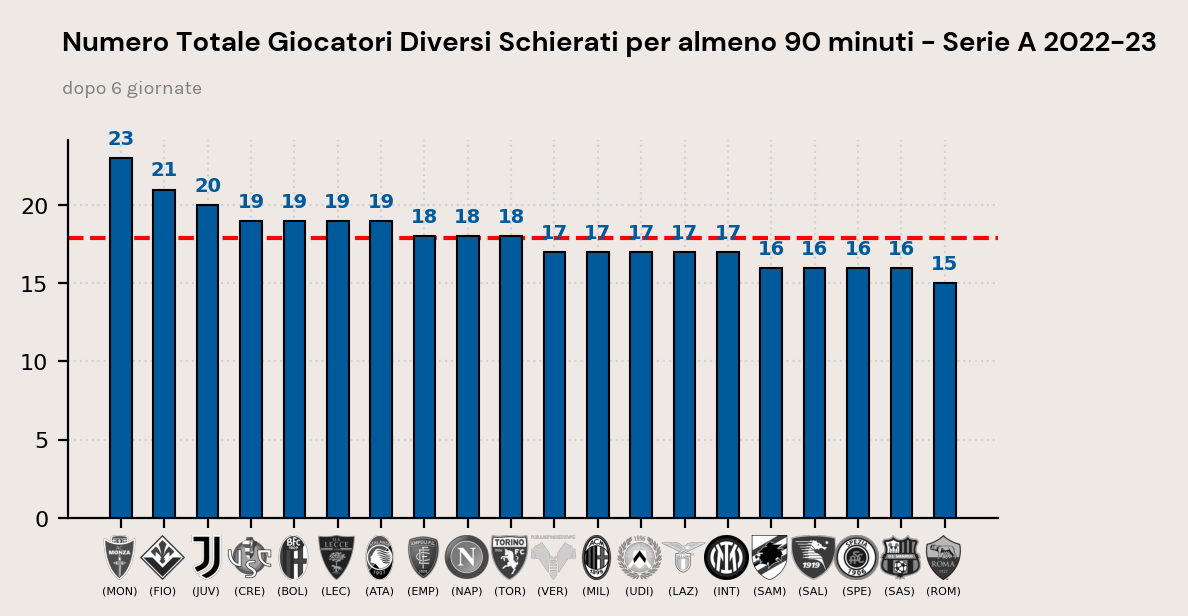

In [40]:
X_2223=different_player_per_team_b.index
height_2223 = different_player_per_team_b.PlayersOnField

sb_2223_avg = different_player_per_team_b['PlayersOnField'].mean()
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")

# We specify the width of the bar
width = 0.5

# Second balls
ax.bar(
    X_2223, 
    height_2223,
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = width,
    label = "Second ball"
)

ax.axhline(y=sb_2223_avg, color='red', linestyle='--', label='average')

for index, y in enumerate(height_2223):
    ax.annotate(
        xy = (index, y),
        text = f"{y:.0f}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 7,
        color = "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

xticks_ = ax.xaxis.set_ticks(
    ticks = X_2223,
    labels = []
    )

ax.tick_params(labelsize = 8)


# --- Axes transformations

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform

# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, team_id in enumerate(different_player_per_team_b["footId"]):
    ax_coords = DC_to_NFC([index - 1.1*width, -4])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.09, 0.09], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")

    logo_ax.annotate(
        xy =(0, 0),
        text = f"({different_player_per_team_b['team'].iloc[index]})",
        xytext = (8, -20),
        textcoords = "offset points",
        size = 4,
        ha = "center",
        va = "center"
    )

fig_text(
    x = 0.12, y = 1.1,
    s = "Numero Totale Giocatori Diversi Schierati per almeno 90 minuti - Serie A 2022-23",
    family = "DM Sans",
    weight = "bold",
    size = 10
)
fig_text(
    x = 0.12, y = 1,
    s = "dopo 6 giornate",
    family = "Karla",
    color = "grey",
    size = 7
)

plt.show()